# **Sampling from the Solution Space of Genome-Scale Metabolic Models**

By 
- [Haris Zafeiropoulos](https://hariszaf.github.io/)        ([hariszaf](https://github.com/hariszaf/))
- [Daniel Rios Garza](https://danielriosgarza.github.io/)   ([danielriosgarza](https://github.com/danielriosgarza/))


July-August, 2025

This notebook accompanies our chapter on the *“Flux Balance Analysis”* book, to be published in the protocol series Methods in Molecular Biology, by Springer Nature.

## **Setting working space**

You can either launch a Codespace based on this repository or run the project locally on your machine.

* **codespace**: Quick and easy to get started. Ideal for initial exploration, but may limit your ability to run custom experiments later on.

* **local**: Requires some setup and may involve troubleshooting environment issues, but gives you full control. Recommended if you plan to use your own data or customize the workflow later.



Here is how to go for each of those two cases.

### **Build a codespace**

To fire a codespace, you will need a GitHub account and then from our [GitHub repo](https://github.com/hariszaf/metabolic_toy_model/tree/sampling), use the `sampling` branch to create your codespace.

* First, click on the arrow on the `Code` button
* then, click on `Codespaces`
* and on the three dots `...`, to create a `New with options...`

![](files/figs/codespace-fire.png)

After you make sure you have the configuration as in the following picture, you may fire your codespace by clicking on the `Create codespace` button:

![](./files/figs/codespace-conf.png)

> **Advanced Tip**
>
> The [`devcontainer.json`](.devcontainer/devcontainer.json) describes the configuration of the codespace to be built. 
> 
> If you pay close attention, you will realise what you would need to make sure for your local build (see next paragraph).

### **Creating a Conda environment**

Here, we assume you have Miniconda or Anaconda installed in your machine. 

If you don't, you can follow [this tutorial](https://eduand-alvarez.medium.com/setting-up-anaconda-on-your-windows-pc-6e39800c1afb).

Also, the following instructions (regarding the environment) are for a Linux environment, but you can adapt them to your OS.
The `dingo` Python package is not available yet for arm64 architecture, so you will need to use an x86_64 machine.


1. Create a Conda environment using Python 3.10 and a name of your choice; in this example, we'll call our environment `sampling`:

```conda create -n sampling -y python=3.10```

2) Activate your environment


```conda activate sampling```

3. We will be using `dingo` for flux sampling on the solution space of a metabolic model. `dingo` requires `PySPQR`; a module that wraps the [SuiteSparseQR](https://people.engr.tamu.edu/davis/suitesparse.html) decomposition function, but comes with a bunch of hard dependencies, based on your operating system. See [here](https://github.com/yig/PySPQR?tab=readme-ov-file#installation) for more. In the following, we assume you are working on Linux and that you have `sudo` rights:

```
sudo apt-get update -y
sudo apt-get install -y libsuitesparse-dev
```

4. You can now install the Python libraries required:

```pip install -r requirements.txt```

You may need the `--user` flag for this step:

```pip install -r requirements.txt --user```

5. You are now ready to go for it! 

In case you are working on VS Code or any other IDLE, make sure to set the kernel of the notebook to the `conda` environment you just built.

For example, if using VS Code, when you will try to run the first chunk of code, you will get a message like this:

![](./files/figs/select_kernel.png)

Then, you can click `Select Another Kernel... > Python Environments...` and you should look for the name of the environment you gave earlier, in our case `sampling`.

However, it's quite possible that IDLE will recognize the new environment after you close and relaunch it. 

In case you wish to use the `PolyRound` library for rounding metabolic models, then you will need to clone the repository and install it as follows:

```bash
git clone https://gitlab.com/csb.ethz/PolyRound.git
cd PolyRound
pip install -e .
cd ..
```

The `PolyRound` argues that their library works better when using Gurobi.

## **Intro**

### **Bio**

We assume the reader/user is already familiar with the basic concepts of metabolic modeling and the basics of the `cobrapy` library. 

If this is not the case, you may **first** go through our according material on [this branch](), we were able to come up with for the 
needs of the [METABOLIC MODELS APPLIED TO MICROBIOMES](https://metabolicmodelingantony2025.onrender.com/) workshop.



As throughout this repository, we use metabolic models from three human gut-associated strains that are known for:

* occupying key ecological niches in the gut, and

* engaging in metabolic interactions with one another, as illustrated in the diagram below:



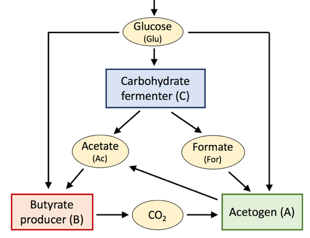

These ecological niches are based on the metabolism of the following three species:

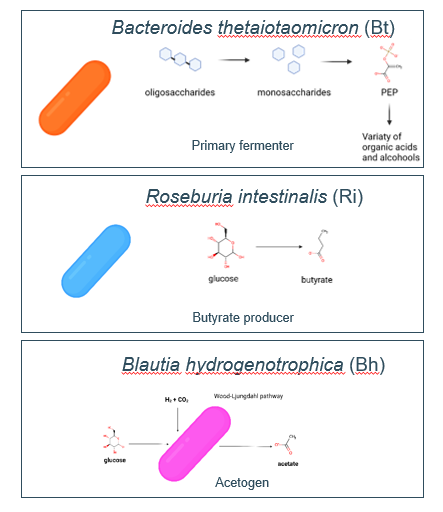

We will run our single-species sampling scenarios using an AGORA model for Bt and only in the community case we will use all three of them. 

### **Technical**

In case your Jupyter notebook does not line with the `sampling` environment, you may give it a shot after running:

In [1]:
import os
import sys

In [ ]:
env_site_packages = os.path.join(os.getenv('CONDA_PREFIX'), 'lib/python3.10/site-packages')  # Adjust for your Python version
if env_site_packages not in sys.path:
    sys.path.append(env_site_packages)

By now, you should be able to load the libraries required for this notebook:

In [2]:
# General
import time
import pickle
import numpy as np
import pandas as pd
from typing import List
from pathlib import Path


# Sampling
import cobra
from cobra import Model
from cobra.sampling import ACHRSampler, OptGPSampler

import dingo
# import dingo_walk as dingo

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

# Local scripts
from scripts.utils import dump_samples, load_samples
from scripts.stats import (
    check_samples_range, 
    pca_samples, plot_hists, count_ios, 
    different_fluxes_over_sign, tsne_dbscan_grid,
    significantly_altered_reactions,
    rxns_cluster_contribution
)

# Stats
import arviz as az
from numpy.typing import NDArray

from sklearn.decomposition import PCA

2025-08-11 22:39:18.422383: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-11 22:39:18.424568: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-11 22:39:18.476932: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-11 22:39:18.478060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-11 22:39:19.399699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Now you are good to keep track of the models to be used. 

In [3]:
root_dir = Path().resolve()

agora_models_path = root_dir / "files" / "models" / "AGORA"

bt_agora_filename = "Bacteroides_thetaiotaomicron_VPI_5482.xml"
bh_agora_filename = "Blautia_hydrogenotrophica_DSM_10507.xml"
ri_agora_filename = "Roseburia_intestinalis_L1_82.xml"

And decide on what **solver** you will be using. 

To solve the optimization problems in our model, a solver is required; special software that can solve a wide range of problem types, such as linear programming, mixed-integer linear programming, quadratic programming, mixed-integer quadratic programming etc.

These problems are rather common in metabolic modelling and most of the analyses performed in the field, are based on solving such optimization problems.

Let's see an example when loading a model with `cobra`:

In [4]:
bh_model = cobra.io.read_sbml_model(agora_models_path / bh_agora_filename)
bh_model.solver

Set parameter Username
Set parameter LicenseID to value 2634947
Academic license - for non-commercial use only - expires 2026-03-11


In case Gurobi for example was available, `cobra` would prefer it and you would seed something like: 
```
>>> bt_model.solver
<optlang.gurobi_interface.Model object at 0x7da11588e9c0>
```

To check what solvers are available on your **environment**, you may run:

In [ ]:
import optlang
print(optlang.available_solvers)

> You can think of Optlang as the SQLAlchemy of optimization
>
> SQLAlchemy isn't a database, but lets you talk to different databases using a unified interface.
>
> Optlang isn't a solver, but lets you talk to different solvers in a unified way.


Latest versions of `cobra` use [`optlang`](https://optlang.readthedocs.io/en/latest/) to describe their linear programs, which works as an interface to a series of solvers that may be available on your computing environment, e.g. GLPK, Gurobi etc. 

[Gurobi](https://www.gurobi.com) requires a paid license, but can also [be obtained](https://www.gurobi.com/downloads/) for free under an [academic license](https://www.gurobi.com/downloads/end-user-license-agreement-academic/). [CPLEX](https://www.ibm.com/products/ilog-cplex-optimization-studio) too. 

On the other hand,[`glpk`](https://www.gnu.org/software/glpk/), [HIGHS](https://ergo-code.github.io/HiGHS/dev/) and others are open source and free. 

`dingo` uses HIGHS as its default solver; `highspy` should already been installed on your environment. 
You can always use the `glpk` instead, but would take considerably longer in Genome Scale models.

Thanks to HIGHS, `dingo` besides `glpk` supports: 

- `highs` 
- `gurobi`
- `copt`
- `mosek`

In [5]:
# Directory to save sample datasets
samples_path = root_dir / "results" / "samples"
os.makedirs(samples_path, exist_ok=True)

## **Sampling scenarios**


While FBA finds a single maximum for the objective function, one might be interested in the space of viable metabolisms. This space reveals the range of conditions where the cell could live without the assumption of maximizing an objective function.

The space of viable metabolisms is explored by taking uniform samples from the flux distribution. Besides revealing the cell's metabolic potential, these samples also reveal the conformations of higher likelihood and the burden of regulation needed for the cell to achieve its "maximum growth". 

In the following we provide examples of how to perform and apply flux sampling to address a range of questions. 

In most parts of the notebook, we will be using an AGORA GEM of *Blautia hydrogenotrophica* (Bh).

In [6]:
bh_xml   = (agora_models_path / bh_agora_filename).as_posix()
bh_model = cobra.io.read_sbml_model(bh_xml)

In [7]:
bh_reactions = [rxn.id for rxn in bh_model.reactions]

In [ ]:
bh_dmodel = dingo.MetabolicNetwork.from_sbml(bh_xml)

### **Random walks, solvers and diagnostics**

We will sample using Bh model, using the two algorithms provided in `cobra` (OptGP and ACHR), and two of those supported by `dingo` (MMCS and Billiard walk), using their default solvers (GLPK and HIGHS correspondingly). 

The sample datasets will be saved as pickle files under `results/samples/`.

In [ ]:
solvers     = ["default", "gurobi"]  # default: GLPK
cobra_walks = ["OptGP", "achr"]
dingo_walks = ["MMCS", "billiard_walk"]

bh_xml = (agora_models_path / bh_agora_filename).as_posix()

# Dictionary with time required for each sampling experiment
times = {}
for solver in solvers:

    for walk in cobra_walks:

        if solver != "default":
            model.solver = "gurobi"
            lsolver = solver
        else:
            lsolver = "glpk"

        print(f"Walk: {walk}, Solver: {lsolver}")

        # Load as cobra model
        model = cobra.io.read_sbml_model(agora_models_path / bh_agora_filename)

        t1 = time.time()
        if walk == "OptGP":
            
            exp     = OptGPSampler(model, thinning=100, processes=4)
            samples = exp.sample(10000)

        elif walk == "achr":
            
            exp = ACHRSampler(model, thinning=100)
            samples = exp.sample(n=10000)

        t2   = time.time()
        case = "_".join([lsolver, walk, "unb"])

        times[case] = f"{t2 - t1:.2f}"
        dump_samples(samples, samples_path/ ".".join([case, "pkl"]) )


    for walk in dingo_walks:

        if solver != "default":
            model.solver = "gurobi"
            lsolver      = solver
        else:
            lsolver = "highs"

        print(f"Walk: {walk}, Solver: {lsolver}")

        # Load as dingo model
        model  = dingo.MetabolicNetwork.from_sbml(bh_xml)

        # Replace the objective function with an empty zero-array
        model.objective_function = np.zeros(model.num_of_reactions())
        
        sampler = dingo.PolytopeSampler(model)
        sampler.set_solver("gurobi")

        if walk == "MMCS":

            samples = sampler.generate_steady_states(ess=3000, psrf=True)

        elif walk == "billiard_walk":

            samples = sampler.generate_steady_states_no_multiphase(
                method   = "billiard_walk",
                n        = 10000,
                burn_in  = 10,
                thinning = 100
            )

        t2   = time.time()
        case = "_".join([lsolver, walk, "unb"])

        times[case] = f"{t2 - t1:.2f}"
        dump_samples(samples, samples_path/ ".".join([case, "pkl"]) )



Load a sample dataset and get its ESS.

In [ ]:
df = load_samples(samples_path / "gurobi_OptGP_unb.pkl")
if isinstance(df, np.ndarray):
    df = pd.DataFrame(
        df, 
        index=[rxn.id for rxn in bh_model.reactions]
    ).T

In [ ]:
# Keep values of the dataframe
data = df.values

# If you are aware of the number of chains produced during sampling, replace None with the number of chains and edit the shape accordingly.
# For example, if you had 10000 samples coming from 4 chains, you should reshape like this: [4, 2500, :]
data = data[None, :, :]
dataset = az.convert_to_dataset({"samples": data})

# Estimate ess
ess = az.ess(dataset)  # by default, method is `bulk`, see: https://python.arviz.org/en/stable/api/generated/arviz.ess.html

In [ ]:
print(
    f"ESS mean: {ess.mean()}\n---\n"
    f"ESS minimun: {ess.min()}"
)

In [ ]:
ess_values        = ess['samples'].values 
low_ess_idx       = (ess_values < 1000).nonzero()[0]
low_ess_reactions = df.columns[low_ess_idx]

count_ex      = 0
count_blocked = 0
count_fixed   = 0
for rxn_id in low_ess_reactions.values:
    if rxn_id.startswith("EX_"):
        count_ex +=1
    else:
        if abs(df[rxn_id].mean() ) < 0.001:
            count_blocked += 1
        elif abs(df[rxn_id].max() - df[rxn_id].min()) < 0.1:
            count_fixed += 1


print(f"Number of exchange reactions on the model: {len(model.exchanges)}")
print(f"Number of total reactions with low ESS: {len(low_ess_reactions.values)}")
print(f"Number of exchange reactions among those with low ESS: {count_ex}")

Now you can load your samples:

In [ ]:
optgp_samples = load_samples(samples_path / "gurobi_OptGP_unb.pkl")
achr_samples  = load_samples(samples_path / "gurobi_achr_unb.pkl")
mmcs_samples  = load_samples(samples_path / "gurobi_MMCS_unb.pkl")
bw_samples    = load_samples(samples_path / "gurobi_billiard_walk_unb.pkl")


And we can plot any marginal distribution we are interested in. 

Below we plot the biomass distribution from all the 4 different walks applied, when using Gurobi as our solver.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

plot_hists(
    optgp_samples, "biomass525", type = "cobra", 
    description = "on Bh using OptGP, unbiased", ax=axes[0, 0]
)
plot_hists(
    achr_samples, "biomass525", type = "cobra", 
    description = "on Bh using ACHR, unbiased", ax=axes[0, 1]
)
plot_hists(
    mmcs_samples, "biomass525", type = "dingo", 
    dingo_model = bh_dmodel, description = "on Bh using MMCS, unbiased", ax=axes[1,0]
)
plot_hists(
    bw_samples, "biomass525", 
    type = "dingo", dingo_model = bh_dmodel, description = "on Bh using Billiard, unbiased", ax=axes[1,1]
)

plt.tight_layout()
plt.savefig("results/samples/optg_achr_mmcs_bW_bh_unbiased2.eps", format="eps", dpi=600)
plt.savefig("results/samples/optg_achr_mmcs_bW_bh_unbiased2.png", format="png", dpi=300)
plt.show()

### **Rounding**


PolyRound is an exceptional Python library specialized in rounding polytopes. 

In [ ]:
from PolyRound.api import PolyRoundApi
from PolyRound.settings import PolyRoundSettings
from PolyRound.static_classes.lp_utils import ChebyshevFinder

# Fix settings
settings         = PolyRoundSettings()
settings.verbose = True
settings.backend = "gurobi"

# Export initial and perform rounding tasks
polytope             = PolyRoundApi.sbml_to_polytope(agora_models_path / bh_agora_filename)
polyrounded_polytope = PolyRoundApi.simplify_transform_and_round(polytope)

Sample using the *polyround-*ed polytope and the MMCS `dingo` algorithm.

In [ ]:
mmcs_polyrouned_samples = dingo.PolytopeSampler.sample_from_polytope(
    np.asarray(polyrounded_polytope.A),
    np.asarray(polyrounded_polytope.b),
    ess  = 1000,
    psrf = True
)

In [ ]:
print(
    f"Dimensions of the samples retrieved from the polyrounde-ed polytope: {mmcs_polyrouned_samples.shape}\n"
    f"Number of reactions in the Bh model: {len(bh_model.reactions)}"
)


Apply back transformation to map samples to their original space. 

In [ ]:
mmcs_poly_samples = polyrounded_polytope.back_transform(mmcs_polyrouned_samples)

In [ ]:
mmcs_poly_samples.shape

In [ ]:
dump_samples(mmcs_poly_samples, "results/samples/bh_mmcs_poly.pkl")

You can sample on the *polyround*-ed polytope, using any kind of sampling algorithm, but you always need to remember to back transform the samples to the original space.

In [ ]:
# Sample on polyrounde-ed polytope using Billiard walk 
bw_polyrounded_samples = dingo.PolytopeSampler.sample_from_polytope_no_multiphase(
    np.asarray(polyrounded_polytope.A),
    np.asarray(polyrounded_polytope.b),
    method   = "billiard_walk",
    n        = 10000,
    thinning = 100
)

# Back tansformation
bw_poly_samples = polyrounded_polytope.back_transform(bw_polyrounded_samples)

### **Computational vs. biological feasibility**

The Bh GEM we are using comes with a *rich* medium, where all model's exchange reactions are available on the `medium`.

In [ ]:
bh_model = cobra.io.read_sbml_model(bh_xml)
bh_model.solver = "gurobi"

In [ ]:
print(
    f"Number of total exchange reactions available in the model: {len(bh_model.exchanges)}\n"
    f"Number of metabolites in the medium of the Bh model with a non-zero flux: {np.count_nonzero(list(bh_model.medium.values()))}"
)

Check whether there are any missing exchange reactions from the medium.

In [ ]:
missing_exchanges = [r.id for r in bh_model.exchanges if r.id not in bh_model.medium]
print(missing_exchanges)

In [ ]:
init_sol = bh_model.optimize()
init_sol.objective_value

Uptake flux of oxygen

In [ ]:
sum = bh_model.summary()
sum.uptake_flux.loc["EX_o2(e)"]

Remove oxygen from model's medium and get optimal biomass.

In [ ]:
bh_model.reactions.get_by_id("EX_o2(e)").lower_bound = 0
sol_no_o2 = bh_model.optimize()
sol_no_o2.objective_value

The GEM of Bh we are using returns a higher optimal biomass when oxygen is present, while it is well known that most Blautia strains are not even tolerant on oxygen.

Check whether oxygen is still being used with parsimonious FBA (pFBA) and given thermodynamics are considered, i.e. infeasible cycles are removed.

In [ ]:
bh_model = cobra.io.read_sbml_model(bh_xml)
bh_model.solver = "gurobi"

In [ ]:
ll_sol = cobra.flux_analysis.loopless_solution(bh_model)
ll_sol.fluxes.loc["EX_o2(e)"]

In [ ]:
psol = cobra.flux_analysis.pfba(bh_model)
psol.fluxes.loc["EX_o2(e)"]

### **Basic statistics on sampling data sets**

Let us now check what happens when we **remove just the oxygen from the medium**, so at least the medium looks a bit more like what's happening in the human gut where Bh lives, forcing our model to skip oxygen utilization.

In [ ]:
# Build a new cobra instance 
bh_model_no_oxygen = cobra.io.read_sbml_model(bh_xml)

# Set lower bound of the uptake reaction for oxygen to zero, "removing" it from the medium
bh_model_no_oxygen.reactions.get_by_id("EX_o2(e)").lower_bound = 0 

# Build a new dingo Model from this cobra model
dmodel = dingo.MetabolicNetwork.from_cobra_model(bh_model_no_oxygen)

# Replace its objective function with the zero-vector
dmodel.objective_function = np.zeros(len(dmodel.reactions))

# Sample unbiased using MMCS
sampler = dingo.PolytopeSampler(dmodel)
unb_anox_samples = sampler.generate_steady_states(ess=1000, psrf=True)


In [ ]:
# Now you are ready to sample in an unbiased way in the anoxic case
sampler          = dingo.PolytopeSampler(bh_dmodel)
unb_anox_samples = sampler.generate_steady_states(ess=1000, psrf=True)

In [ ]:
dump_samples(unb_anox_samples, samples_path / "bh_unb_anoxic.pkl")

In [ ]:
unb_anox_samples = load_samples(samples_path / "bh_unb_anoxic.pkl")
unb_anox_samples = pd.DataFrame(unb_anox_samples, index = bh_reactions).T

Let us now check how much of the variability on the dataset the first 10 components of a PCA explain:

In [ ]:
pca_samples(unb_anox_samples, plots=True, outfile = samples_path / "bh_pca_anox_unb")

In [ ]:
print(
    unb_anox_samples["EX_lac_D(e)"].min(),
    unb_anox_samples["EX_lac_D(e)"].max()
)

Significantly different fluxes between samples consuming and producing lactate:

In [ ]:
sig_cols, pos, neg, dddf = different_fluxes_over_sign(unb_anox_samples, "EX_lac_D(e)", bh_model)

In [ ]:
dddf

In [ ]:
dddf["Reaction name"]

### Unbiased oxygen - no oxygen case

Let us check how many different input-output cases we have in the unbiased sampling with MMCS and Gurobi.

In [ ]:
bh_model_no_oxygen = cobra.io.read_sbml_model(bh_xml)
bh_model_no_oxygen.reactions.get_by_id("EX_o2(e)").lower_bound = 0 

dmodel = dingo.MetabolicNetwork.from_cobra_model(bh_model_no_oxygen)
dmodel.objective_function = np.zeros(len(dmodel.reactions))

sampler = dingo.PolytopeSampler(dmodel)

unb_no_oxygen = sampler.generate_steady_states(ess=1000, psrf=True)

In [ ]:
dump_samples(unb_no_oxygen, samples_path / "mmcs_unb_no_oxyg_bh.pkl")

If you have already your samples:

In [ ]:
unb_samples = load_samples(samples_path / "gurobi_MMCS_unb.pkl")
unb_anox_samples =  load_samples(samples_path / "bh_unb_anoxic.pkl")

Count unique input/output exchange vectors in the anoxic samples dataset:

In [ ]:
anoxic_uniq_ios = count_ios(unb_anox_samples, bh_model)  # count_ios(unb_anox_samples, bh_model, "biomass525")

In [ ]:
anoxic_uniq_ios.shape

When oxygen included 2443 cases, while when not only 1160.

In [ ]:
unb_anox_samples = pd.DataFrame(unb_anox_samples, index = bh_reactions).T

Here, oxygen uptake is absent across all samples.

In [ ]:
unb_anox_samples["EX_o2(e)"].eq(0).all()

In [ ]:
no_oxy_samples = pd.DataFrame(unb_no_oxygen, index=bh_reactions).T
no_oxy_samples["EX_o2(e)"].mean()


In [ ]:
unb_samples = load_samples(samples_path / "gurobi_MMCS_unb.pkl")
unb_samples = pd.DataFrame(unb_samples, index = bh_reactions).T

In [ ]:
unique_io = count_ios(unb_samples, bh_model)

In [ ]:
unique_io.shape

In [ ]:
# unb_samples["EX_glc_D(e)"].mean()
unb_samples["EX_o2(e)"].mean()

There are 2443 combinations of active exchange reactions in the complete medium of the model; all of them including the uptake of oxygen.

This is not possible for Bh, highlighting two key challenges in constraint-based analysis in metabolic modeling in general that sampling inherits:

- medium effect 
- how do we constrain the solution space enough to have biological relevance


### **Biased sampling: optimal and suboptimal cases**

Build new model without oxygen on its medium, and forbidding lactate uptake

In [8]:
def model_prune_medium(exchanges_to_mute=[]):

    bh_model_no_oxyg = cobra.io.read_sbml_model(
        agora_models_path / bh_agora_filename
    )
    for rxn_id in exchanges_to_mute:
        bh_model_no_oxyg.reactions.get_by_id(rxn_id).lower_bound    = 0

    d_model  = dingo.MetabolicNetwork.from_cobra_model(bh_model_no_oxyg)

    return d_model

In [9]:
d_model = model_prune_medium(["EX_o2(e)", "EX_lac_D(e)"])

First, sample in the optical case: 


In [10]:
sampler = dingo.PolytopeSampler(d_model)
sampler.set_solver("gurobi")


In [ ]:
no_lac_ox_opt = sampler.generate_steady_states(ess=1000,psrf=True)

Set parameter Username
Set parameter LicenseID to value 2634947
Academic license - for non-commercial use only - expires 2026-03-11
phase 1: number of correlated samples = 3600, effective sample size = 20, ratio of the maximum singilar value over the minimum singular value = 4339.45
phase 2: number of correlated samples = 3600, effective sample size = 25, ratio of the maximum singilar value over the minimum singular value = 52657.5
phase 3: number of correlated samples = 3600, effective sample size = 25, ratio of the maximum singilar value over the minimum singular value = 1418.14
phase 4: number of correlated samples = 3600, effective sample size = 26, ratio of the maximum singilar value over the minimum singular value = 781.319
phase 5: number of correlated samples = 3600, effective sample size = 877, ratio of the maximum singilar value over the minimum singular value = 18.6968



 [1]maximum marginal PSRF: 1.97646
[2]maximum marginal PSRF: 3.0409
[2]total ess: 1073
[2]maximum marginal PSRF: 1.74791
[2]total ess: 1048
[2]maximum marginal PSRF: 2.09483
[2]total ess: 1023
[2]maximum marginal PSRF: 1.0786
[2]total ess: 997
[3]maximum marginal PSRF: 1.0786


phase 6: number of correlated samples = 500, effective sample size = 120[3]total ess 997: number of correlated samples = 4100


phase 7: number of correlated samples = 100, effective sample size = 11
[4]total ess 1008: number of correlated samples = 4200




[4]maximum marginal PSRF: 1.07113


In [12]:
no_lac_ox_opt = pd.DataFrame(no_lac_ox_opt, index=bh_reactions).T

In [13]:
dump_samples(no_lac_ox_opt, samples_path / "bh_no_ox_lac_opt_mmcs.pkl")

Now, repeat the process, but require not optimal, but at least 50% of the optimal biomass.

In [15]:
d_model = model_prune_medium(["EX_o2(e)", "EX_lac_D(e)"])
d_model.set_opt_percentage(50)

In [16]:
sampler = dingo.PolytopeSampler(d_model)
sampler.set_solver("gurobi")

In [17]:
no_lac_ox_opt50 = sampler.generate_steady_states(ess=1000,psrf=True)

phase 1: number of correlated samples = 3600, effective sample size = 25, ratio of the maximum singilar value over the minimum singular value = 5360.73
phase 2: number of correlated samples = 3600, effective sample size = 1069


 [1]maximum marginal PSRF: 2.38206
[2]maximum marginal PSRF: 1.00444
[2]total ess: 1069


In [18]:
no_lac_ox_opt50 = pd.DataFrame(no_lac_ox_opt50, index=bh_reactions).T

In [19]:
dump_samples(no_lac_ox_opt, samples_path / "bh_no_ox_lac_opt50_mmcs.pkl")

In case sampling datasets already there, just load them:

In [ ]:
no_lac_ox_opt   = load_samples(samples_path / "bh_no_ox_lac_opt_mmcs.pkl")
no_lac_ox_opt50 = load_samples(samples_path / "bh_no_ox_lac_opt50_mmcs.pkl")

Check minimum and maximum values of biomass in the two sample datasets:

In [23]:
no_lac_ox_opt["biomass525"].min(), no_lac_ox_opt["biomass525"].max()

(78.25516300000054, 78.25516302134942)

In [24]:
no_lac_ox_opt50["biomass525"].min(), no_lac_ox_opt50["biomass525"].max()

(39.12768640607325, 42.18425337203762)

Notice that in the half-optimal case, biomass gets fluxes only quite close to the minimum (half-optimal) bound. 
No sample with a biomass close to the optimal is recorded. 
This is rather indicative of the polytope's topology, where biomass is rather skinny area.

This also explain the following observation:

Compare number of fixed fluxes in the optimal and half-optimal cases:

In [21]:
breaching_bound, non_fixed = check_samples_range(no_lac_ox_opt)

Number of reactions whose bounds failed: 4
Number of reaction with a non-fixed flux: 155


In [22]:
breaching_bound_opt50, non_fixed_opt50 = check_samples_range(no_lac_ox_opt50)

Number of reactions whose bounds failed: 0
Number of reaction with a non-fixed flux: 619


Let us check now what PCA could tell us on the optimal and suboptimal cases, where neither oxygen nor lactose can be used.

In [30]:
no_lac_ox_opt_clip = no_lac_ox_opt.clip(lower=-1000, upper=1000)

Explained Variance Ratio: [0.11334639 0.0315976  0.02425855 0.02136779 0.01998801 0.01719195
 0.01599109 0.01553301 0.01412115 0.01295251]


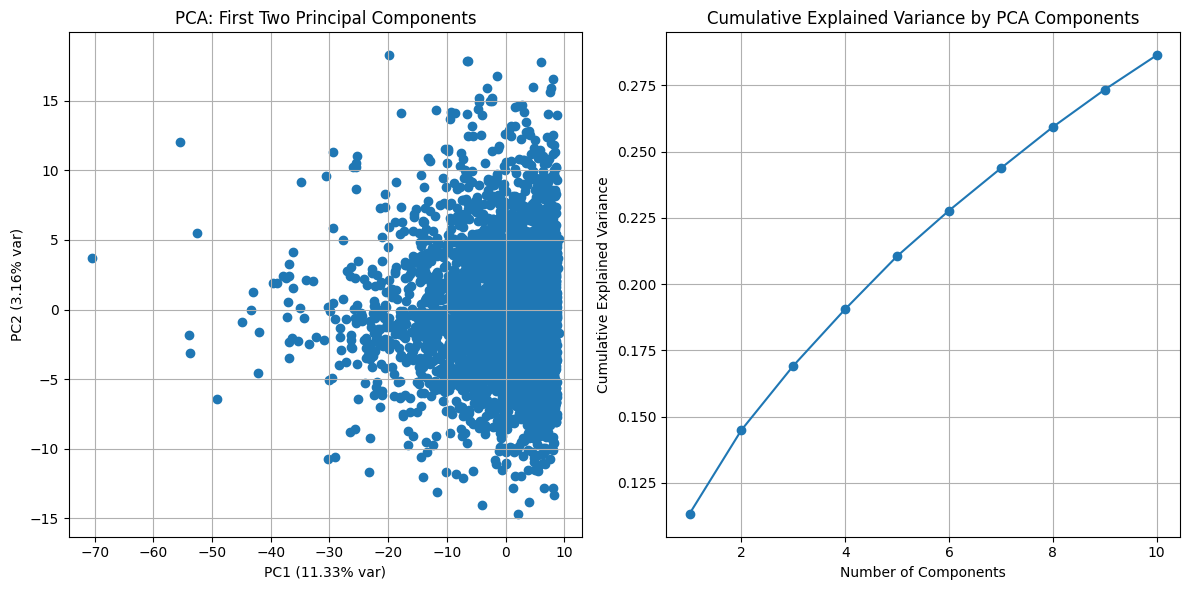

In [46]:
d, pca_model = pca_samples(no_lac_ox_opt_clip, plots=True, outfile = samples_path / "bh_pca_no_oxyg_lac_opt")

In [33]:
bh_model.reactions.get_by_id("2AHBUTI")

Reaction identifier,2AHBUTI
Name,(S)-2-Aceto-2-hydroxybutanoate isomerase
Memory address,0x7a428987aad0
Stoichiometry,2ahbut[c] <=> 3h3mop[c] (S)-2-Aceto-2-hydroxybutanoate <=> (R)-3-Hydroxy-3-methyl-2-oxopentanoate
GPR,476272.5.peg.1465
Lower bound,-1000.0
Upper bound,1000.0


In [34]:
no_lac_ox_opt["2AHBUTI"].min(), no_lac_ox_opt["2AHBUTI"].max()

(-987.9218180692312, 999.4664148433312)

In [35]:
no_lac_ox_opt50_clip = no_lac_ox_opt50.clip(lower=-1000, upper=1000)

Explained Variance Ratio: [0.11339864 0.03579768 0.02183829 0.01960704 0.01869425 0.01780289
 0.0165466  0.01631683 0.01548955 0.01497225]


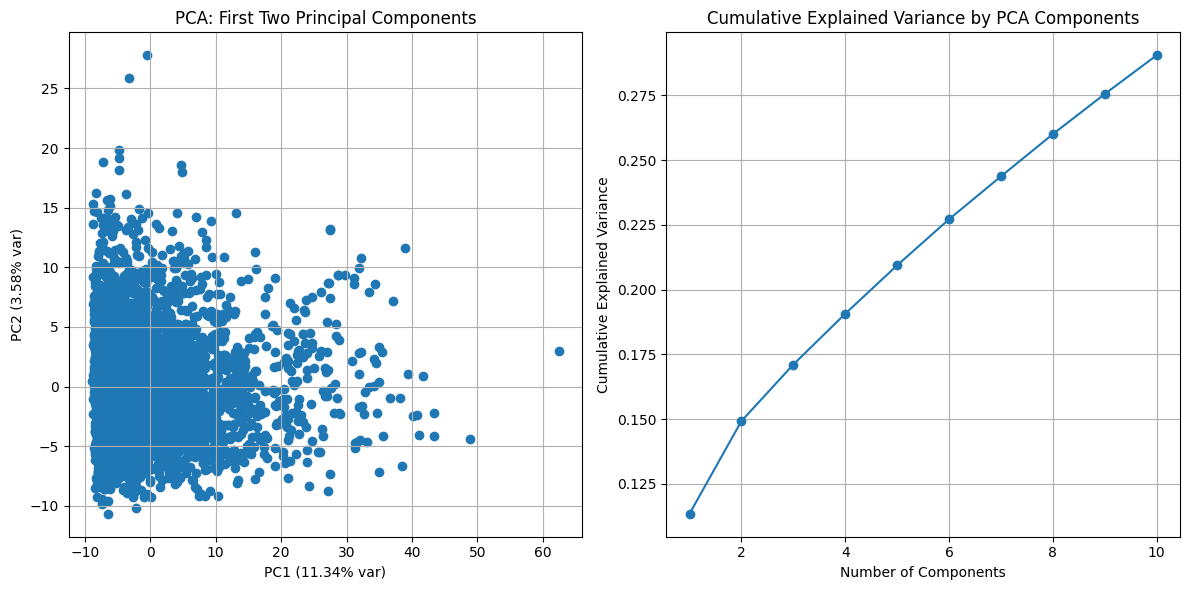

In [45]:
d50, pca_model50 = pca_samples(no_lac_ox_opt50_clip, plots=True, outfile = samples_path / "bh_pca_no_oxyg_lac_opt50")

In [39]:
no_lac_ox_opt50_clip["HSDx"].min(), no_lac_ox_opt50_clip["HSDx"].max()

(-999.7988359804531, 999.3227197527115)

In [37]:
bh_model.reactions.HSDx

Reaction identifier,HSDx
Name,homoserine dehydrogenase (NADH)
Memory address,0x7a42896bea10
Stoichiometry,hom_L[c] + nad[c] <=> aspsa[c] + h[c] + nadh[c] L-homoserine + Nicotinamide adenine dinucleotide <=> L-Aspartate 4-semialdehyde + proton + Nicotinamide adenine dinucleotide - reduced
GPR,476272.5.peg.1589 or 476272.5.peg.846
Lower bound,-1000.0
Upper bound,1000.0


In [105]:
rxns_per_subsystem = {}
for rxn in bh_model.reactions:
    if rxn.subsystem not in rxns_per_subsystem:
        rxns_per_subsystem[rxn.subsystem] = []
    rxns_per_subsystem[rxn.subsystem].append(rxn.id)

In [106]:
rxns_per_subsystem.keys()

dict_keys(['Valine, leucine, and isoleucine metabolism', 'Lysine metabolism', 'Glycerophospholipid metabolism', 'Fatty acid synthesis', 'Arginine and proline metabolism', 'Vitamin B6 metabolism', 'Purine catabolism', 'Glycolysis/gluconeogenesis', 'Pentose and glucuronate interconversions', 'Pyruvate metabolism', 'Tropane, piperidine and pyridine alkaloid biosynthesis', 'beta-Alanine metabolism', 'Transport, extracellular', 'Vitamin B12 metabolism', 'Propanoate metabolism', 'Aminosugar metabolism', 'Urea cycle', 'Fatty acid oxidation', 'CoA synthesis', 'Butanoate metabolism', 'Folate metabolism', 'Nucleotide interconversion', 'Nucleotide salvage pathway', 'Purine synthesis', 'Phosphonate and phosphinate metabolism', 'Alanine and aspartate metabolism', 'Methionine and cysteine metabolism', 'Thiamine metabolism', 'Peptide metabolism', 'Starch and sucrose metabolism', 'Glutathione metabolism', 'Tryptophan metabolism', 'Glycine, serine, alanine, and threonine metabolism', 'Pyrimidine synthe

In [161]:
# cor_matrix, cor_dict = correlated_reactions(no_lac_ox_opt50_clip, rxns_per_subsystem["Lysine metabolism"], subsystem="Lysine metabolism")
subsys = 'Glycolysis/gluconeogenesis'
cor_matrix, cor_dict = correlated_reactions(no_lac_ox_opt_clip, rxns_per_subsystem[subsys], subsystem=subsys)
cor_matrix, cor_dict = correlated_reactions(no_lac_ox_opt50_clip, rxns_per_subsystem[subsys], subsystem=subsys)

/opt/miniconda3/envs/sampling/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/opt/miniconda3/envs/sampling/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



/opt/miniconda3/envs/sampling/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/opt/miniconda3/envs/sampling/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



In [56]:
importance = rxns_cluster_contribution(no_lac_ox_opt50_clip, dbscan_labels)

In [85]:
importance.head(10)

PPCDC           0.007565
BPNT            0.006817
FE3abc          0.006469
PTPAT           0.005903
EX_mg2(e)       0.005812
MNt2            0.005521
EX_zn2(e)       0.005245
EX_ribflv(e)    0.004449
DPCOAK          0.004415
PYDXK           0.004246
dtype: float64

In [87]:
dingo.illustrations.plot_copula(
    data_flux1 = [no_lac_ox_opt50_clip["FE3abc"], "FE3abc"], 
    data_flux2 = [no_lac_ox_opt50_clip["PPCDC"], "PPCDC"], 
    n = 10
)

In [ ]:
s, p, n = different_fluxes_over_sign(no_oxyg_opt, "2AHBUTI")

In [ ]:
significantly_altered_reactions(
    conditions  = [no_oxyg_opt[no_oxyg_opt["2AHBUTI"]>=0], no_oxyg_opt[no_oxyg_opt["2AHBUTI"] < 0]],
    cobra_model = bh_model
)

In [ ]:
for rxn in sig:
    p = pos[rxn].mean()
    n = neg[rxn].mean()
    if p * n < -1:
        
        r = bh_model.reactions.get_by_id(rxn)
        print(rxn)
        print(r.name)
        print(r.build_reaction_string(use_metabolite_names = True))
        print(r.build_reaction_string())

        print("mean in positive NDPK1: ", p)
        print("mean in negative NDPK1: ", n)
        print("reactants: ", r.reactants)
        print("products: ", r.products, "\n---")

In [ ]:
(unb_anox_samples["ACKr"].min(), unb_anox_samples["ACKr"].max())


In [ ]:
unb_anox_samples["ACKr"].max()

In [ ]:
sc, pr, nr = different_fluxes_over_sign(unb_anox_samples, "ACKr")
rxns_with_opposite_dir(sc, pr, nr)

### **tmp**

In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

significant_columns, positive_rows, negative_rows = different_fluxes_over_sign(mmcs_samples, rxn_id="ACKr")

In [ ]:
for rxn_id in significant_columns:
    if positive_rows[rxn_id].mean() * negative_rows[rxn_id].mean() < 1:
        print(bh_cmodel.reactions.get_by_id(rxn_id).build_reaction_string(use_metabolite_names=True))
        print(
            rxn_id, 
            f"\nmean of {rxn_id} on positive samples {positive_rows[rxn_id].mean()} \nvs\n "
            f"mean of {rxn_id} on negative samples {negative_rows[rxn_id].mean()}"
            "\n---\n"
        )

In [ ]:
bh      = (agora_models_path / bh_agora_filename).as_posix()



model   = dingo.MetabolicNetwork.from_sbml(bh)
# sampler = dingo.PolytopeSampler(model)
# sampler.set_solver("gurobi")
# bh_opt_samples = sampler.generate_steady_states(ess=3000, psrf=True)

In [ ]:
model.lb

In [ ]:
bh      = (agora_models_path / bh_agora_filename).as_posix()
model   = dingo.MetabolicNetwork.from_sbml(bh)
model.set_opt_percentage(50)
model.lb

In [ ]:
sampler = dingo.PolytopeSampler(model)
sampler.set_solver("gurobi")
bh_half_opt_samples = sampler.generate_steady_states(ess=3000, psrf=True)

In [ ]:
sign_cols   , pos_rows,    neg_rows    = different_fluxes_over_sign(bh_opt_samples, rxn_id="EX_lac_D(e)", reactions_list=bh_dmodel.reactions)
sign_cols_05, pos_rows_05, neg_rows_05 = different_fluxes_over_sign(bh_half_opt_samples, rxn_id="EX_lac_D(e)", reactions_list=bh_dmodel.reactions)

In [ ]:
for rxn_id in sign_cols_05:
    if pos_rows_05[rxn_id].mean() * neg_rows_05[rxn_id].mean() < 1:
        print(bh_cmodel.reactions.get_by_id(rxn_id).build_reaction_string(use_metabolite_names=True))
        print(
            rxn_id, 
            f"\nmean of {rxn_id} on positive samples {pos_rows_05[rxn_id].mean()} \nvs\n "
            f"mean of {rxn_id} on negative samples {neg_rows_05[rxn_id].mean()}"
            "\n---\n"
        )

In [ ]:
dump_samples(bh_opt_samples, "results/samples/bh_opt_mmcs.pkl")

In [ ]:
bh      = (agora_models_path / bh_agora_filename).as_posix()
bh_cmodel = cobra.io.read_sbml_model(bh)

In [ ]:
bh_cmodel.reactions.get_by_id("EX_lac_L(e)")

In [ ]:
bh_cmodel.reactions.get_by_id("EX_lac_L(e)").lower_bound = 0
# bh_cmodel.reactions.get_by_id("EX_lac_L(e)").upper_bound = 0

In [ ]:
bh_dmodel_no_lac = dingo.MetabolicNetwork.from_cobra_model(bh_cmodel)

In [ ]:
sampler = dingo.PolytopeSampler(bh_dmodel_no_lac)
samples_no_lac_opt = sampler.generate_steady_states(ess=2000, psrf=True)

In [ ]:
dump_samples(samples_no_lac_opt, "results/samples/bh_opt_no_lac.pkl")

In [ ]:
from tqdm import tqdm
from cobra.flux_analysis.loopless import loopless_solution

samples_no_lac_opt_ll = get_loopless_solutions_from_samples(samples_no_lac_opt, bh_cmodel)

In [ ]:

plot_hist(bh_opt_samples, "EX_lac_L(e)", type="dingo", description = "Bh, MMCS opt, rich", dingo_model=bh_dmodel)

plot_hist(samples_no_lac_opt, "EX_lac_L(e)", type="dingo", description = "Bh, MMCS opt, no lac", dingo_model=bh_dmodel)

plot_hist(samples_no_lac_opt_ll, "EX_lac_L(e)", type="dingo", description = "Bh, MMCS opt, no lac, ll", dingo_model=bh_dmodel)



In [ ]:
np.all(mmcs_samples["ACOCT"]==0)

In [ ]:
sns.kdeplot(data, bw_adjust=0.1)
sns.rugplot(data, color="black")
plt.title("Biomass marginal distribution, optimizing for biomass")
plt.show()

Biomass value is actually fixed, as supposed to. 

In [ ]:
mmcs_samples_df = pd.DataFrame.from_records(mmcs_samples, index=bh_dmodel.reactions).T

In [ ]:
mmcs_samples_df[(mmcs_samples_df["ACKr"]>0) & (mmcs_samples_df["biomass525"]>0)]

In [ ]:
print(
    bh_cmodel.reactions.get_by_id("ACKr").build_reaction_string(use_metabolite_names=True),
    bh_cmodel.reactions.get_by_id("ACKr").reactants
)

In [ ]:

# transpose: rows = samples, columns = reactions
ess = az.ess(np.asarray(df.T))  # array shape (n_samples, n_reactions)


In [ ]:
lags = [1, 2, 3]
autocorrs_by_lag = {lag: df.apply(lambda col: col.autocorr(lag=lag)) for lag in lags}
autocorr_df = pd.DataFrame(autocorrs_by_lag)

Lactate comes into the cell from the in silico environment, it passes through the periplasm and then it converts to pyruvate! 

### **Sampling the Metabolic Environment**

In [ ]:
from scripts.envBallScripts import *

model     = cobra.io.read_sbml_model(agora_models_path / 'Bacteroides_thetaiotaomicron_VPI_5482.xml')
exchanges = get_exchange_metabolites(model)

envBall = gen_environment_ball(
    exchanges,
    anaerobic=True,
    fixed_reactions={'EX_h2o(e)': 100},
    size=1000,
    total_flux=100,
    seed=666
)

solutions = apply_env_ball(model, envBall)

results_folder = root_dir / 'results' / 'env_ball'
os.makedirs(results_folder, exist_ok=True)

outputPath = results_folder / 'env_ball_reactions_cluster_bt.png'
plot_flux_heatmap(solutions, outputPath)

### **Panreactome (pangenome)**

In [ ]:
from scripts.build_pan_reactomes import make_panReactome, add_exchange, generate_binary_presence_matrix


model_folder = root_dir / 'files' / 'models' / 'AGORA' / 'pan_genome'

models = os.listdir(model_folder)

model = cobra.io.read_sbml_model(
    os.path.join(model_folder, 'Bacteroides_thetaiotaomicron_VPI_5482.xml')
)

for reaction in model.reactions:
    if reaction.objective_coefficient == 1.0:
        objective = reaction.copy()

preact = make_panReactome(model_folder, 'Bacteroides_panreactome')

# Path where we save the image and reaction presence absence table
results_folder = root_dir / 'results' / 'pan_reactome'
os.makedirs(results_folder, exist_ok=True)

# Build a presence/absence of reactions across the Bacteroides genus
generate_binary_presence_matrix(
    model_folder,
    preact,
    results_folder
)

add_exchange(preact)
preact.add_reactions([objective])
preact.reactions.get_by_id(objective.id).objective_coefficient = 1.0

solution  = preact.optimize()
print(f"Objective Value: {solution.objective_value: .2f}")

# cobra.io.write_sbml_model(preact, os.path.join(results_folder, 'bacteroides_pan_reactome.xml'))



### **panEFMs**

In [ ]:
from scripts.envBallScripts import get_exchange_metabolites, gen_environment_ball
from scripts.get_panEFMs import  get_panEFM_dist, plot_reaction_freq_heatmap

In [ ]:
# Import panreactome model 
model_path = root_dir / 'results' / 'pan_reactome' / 'bacteroides_pan_reactome.xml'
model      = cobra.io.read_sbml_model(model_path)

# Keep track of exchange reactions of the panreactome model
exchanges = get_exchange_metabolites(model)

# Build ball with 5 random media using Dirichlet distribution, makins sure it stays anaerobic
envBall = gen_environment_ball(
    exchanges,
    anaerobic       = True,
    fixed_reactions = {'EX_h2o(e)': 100},
    size            = 5,
    total_flux      = 100,
    seed            = 666
)

reactions = [i.id for i in model.reactions if i.objective_coefficient == 0]

pan_efms = {}

for i in envBall:

    print(f"Environment Simulation: {i}")
    pan_efms[i] = get_panEFM_dist(model_path, reactions, envBall[i], max_it=10)
    

# Build dataframe with distances 
frequency_df = pd.DataFrame(
    {env: np.mean(pan_efms[env], axis=0) for env in pan_efms}, 
    index=reactions
).T


results_folder = root_dir / 'results' / 'pan_efms'
os.makedirs(results_folder, exist_ok=True)

output_path = results_folder / 'pan_efms_dist.png'
plot_reaction_freq_heatmap(frequency_df, output_path=output_path, figsize=(12, 8), cmap="coolwarm")


### **Sampling the environment in a community context**

In [ ]:
from scripts.mambo import *

In [ ]:
acetogen          = cobra.io.read_sbml_model(agora_models_path / 'Blautia_hydrogenotrophica_DSM_10507.xml')
sugar_fermenter   = cobra.io.read_sbml_model(agora_models_path / 'Bacteroides_thetaiotaomicron_VPI_5482.xml')
butyrate_producer = cobra.io.read_sbml_model(agora_models_path / 'Roseburia_intestinalis_L1_82.xml')

# Make a list of all the exchange reactions across the three models
exchanges = get_exchange_metabolites(acetogen)
exchanges = exchanges.union(get_exchange_metabolites(sugar_fermenter))
exchanges = exchanges.union(get_exchange_metabolites(butyrate_producer))

# Build a medium where each exchange reaction is present with a boundary of 1
media = {i: 1 for  i in exchanges}

# Apply this medium and solve an FBA
apply_environment(acetogen, media)
apply_environment(sugar_fermenter, media)
apply_environment(butyrate_producer, media)

Below we have a short function to wrap the run MAMBO test parts:

In [ ]:
def run_mambo(modelList, composition, media):

    medias    = [np.array(list(media.values()))]
    solutions = [current_solution(modelList, media)]

    for i in tqdm(range(1000)):  # Should be much larger

        solution, media = MCMC(media, modelList, composition, delta = 10)

        if i > 10:  # Should be much larger

            medias.append(np.array(list(media.values())))
            solutions.append(solution)

    medias  = np.array(medias)
    mediasM = medias.copy()
    medias  = medias.T

    maxMedias = np.max(mediasM, axis=1)
    mediasM   = np.array([mediasM[i]/maxMedias[i] for i in range(len(maxMedias))]).T

    mSols        = solutions.copy()
    solutions    = np.array(solutions).T
    maxSolutions = np.max(mSols, axis=1)
    mSols        = np.array([mSols[i]/maxSolutions[i] for i in range(len(maxSolutions))]).T

    # Pearson correlation between each solution returned and the composition vector
    cor = np.array([sts.pearsonr(i, composition)[0] for i in solutions.T])
    print(f"Correlation: {cor}")

    avM = np.median(medias.T[cor>max(cor)*0.99], axis=0)
    avM = (avM/max(avM))*10

    m = {list(media.keys())[i]: avM[i] for i in range(len(avM))}

    print(f"composition was {composition} \t MAMBO solution was: {current_solution(modelList, m)}")

    sorter     = np.argsort(cor)
    result     = medias.T[sorter].T
    cor_sorted = cor[sorter]

    return result, cor_sorted

In this approach, the order that the taxa and their abundances appear are crucial. 
You need to keep in the same order the species you have in your `modelList` with their relative abundance in the `composition`

In [ ]:
# Order is critical, and in line with the `composition` list below
modelList = [acetogen, sugar_fermenter, butyrate_producer]

In [ ]:
# Composition vector: butyrate producer wins, since 10 (highest value) is on the last position of the list
composition = np.array([1, 0.1, 10])

# Run MAMBO for the butyrate producer winning case
result, cor_sorted = run_mambo(modelList=modelList, composition=composition, media=media)

# Build a folder for our findings if not already there
results_folder = root_dir / 'results' / 'mambo'
os.makedirs(results_folder, exist_ok=True)

# Save plot
output_path = results_folder / 'mambo_butyrateProducerWins.png'
plot_mambo_results(result, cor_sorted, output_path=output_path)

We can do the same for the case where the acetogen wins 

In [ ]:
# Set acetogen (first in the modelList) with the highest abundance (winning)
composition = np.array([10, 1, 0.1])

# Run MAMBO with acetogen-winning composition vector
result, cor_sorted = run_mambo(modelList, composition, media)

output_path = results_folder / 'mambo_acetogenWins.png'
plot_mambo_results(result, cor_sorted, output_path=output_path)

and similarly for the sugar fermentor

In [ ]:
# Set sugar fermentor (second in the modelList) with the highest abundance (winning)
composition = np.array([1, 10, 0.1])

# Run MAMBO for the sugar fermentor case
result, cor_sorted = run_mambo(modelList, composition, media)

output_path = results_folder / 'mambo_sugarFermenterWins.png'
plot_mambo_results(result, cor_sorted, output_path=output_path)

### **depr**

We will go through the solution of the $Bh$ model, using its original medium, to have some first insight of what the model is suggesting 

We can solve the model using flux balance analysis, which maximizes the objective function (usually biomass). This means obtaining the maximum flux value that is allowed to run through our objective function (referred to as the "objective value"). This also gives a solution for the optimal flux of each reaction.

In [ ]:
bh_sol, bh_up, bh_sec, bh_cs = fba_insight(bh_model)

In [ ]:
bh_cs.keys()

When we removed the compounds that are not in the cytosol from the medium, we already observe a decrease biomass and 
also, that fucose is now among the uptake reactions with a flux.


[here is why](https://pubmed.ncbi.nlm.nih.gov/6421801/)



We will go through the solution of the $Bh$ model, using its original medium, to have some first insight of what the model is suggesting 

We can solve the model using flux balance analysis, which maximizes the objective function (usually biomass). This means obtaining the maximum flux value that is allowed to run through our objective function (referred to as the "objective value"). This also gives a solution for the optimal flux of each reaction.

In [ ]:
bh_sol, bh_up, bh_sec, bh_cs = fba_insight(bh_model)


# When we removed the compounds that are not in the cytosol from the medium, we already observe a decrease biomass and 
# also, that fucose is now among the uptake reactions with a flux.


# [here is why](https://pubmed.ncbi.nlm.nih.gov/6421801/)


In [ ]:
medium_compounds = []
not_in_cytosol   = []
for ex, bound in bt_cobra.medium.items(): 
    ex1 = ex.strip("(e)")
    ex1 = ex1.strip("EX_")
    try: 
        m = bt_cobra.metabolites.get_by_id(ex1 + "[c]")
        medium_compounds.append((m.name, m.id))
    except:
        not_in_cytosol.append(ex)
        pass


print(
    "medium_compounds: ", len(medium_compounds), 
    "not_in_cytosol: ", len(not_in_cytosol),
    "overall: ", len(bt_cobra.medium)
)

In [ ]:
bt_cobra.metabolites.get_by_id("fru[c]")
bt_cobra.metabolites.get_by_id("lac_D[c]")

It also secretes: acetate, alanine, h2, nh4, serine, succinate.

In [ ]:
trunc_medium = bt_cobra.medium.copy()
for i in not_in_cytosol:
    del trunc_medium[i]
len(trunc_medium)

In [ ]:
bt_cobra.medium  = trunc_medium
bt_trunc_summary = bt_cobra.summary()
sol_trunc        = bt_cobra.optimize()

In [ ]:
bt_trunc_summary.uptake_flux.sort_values("flux")

In [ ]:
d_model.reactions.index("ADK1")

In [ ]:
sampler =  dingo.PolytopeSampler(d_model)
sampless = sampler.generate_steady_states_no_multiphase(n=100)

In [ ]:
d_model.lb[20]

In [ ]:
broken, _ = check_samples_range(samples)

In [ ]:
broken

In [ ]:
rxn_id = "ADK1"
index = d_model.reactions.index(rxn_id)
d_model.lb[index], d_model.ub[index], samples[rxn_id].min(), samples[rxn_id].max()

In [ ]:
np.argmin(d_model.lb)
d_model.lb[138]

print(len(d_model.lb))

In [ ]:
d_model.lb

In [ ]:
d_model.reactions.index("EX_lac_D(e)")
d_model.lb[435]